```
This software is part of GPU Ocean. 

Copyright (C) 2024 SINTEF Digital

Minimalistic example for running the simplified ocean model nested
within the forecast produced by an operational 3D ocean model.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Florian PhD thesis

Based on https://github.com/havahol/miscGPUOcean/blob/main/demos/demo-deterministicSimulation.ipynb

In [1]:
# Load required modules
%matplotlib inline

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl

import numpy as np

In [2]:
# Import relevant modules from within GPU Ocean
from gpuocean.SWEsimulators import GPUOceanSim
from gpuocean.utils import IPythonMagic, NetCDFInitialization, PlotHelper

In [3]:
# Create the GPU context
%cuda_context_handler gpu_ctx

In [4]:
# Url or path to operational ocean forecast
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

# Use a predefined subdomain
casename = 'lofoten'

# Load initial and boundary conditions, bathymetry, landmask, forcing, etc
sim_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url, casename)

In [5]:
# Create simulation object
sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(sim_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


## Nesting

In [6]:
from netCDF4 import Dataset
nc = Dataset(source_url)
op_y0, op_y1 = 350, 850
op_x0, op_x1 = 1250, 2100
op_velo = np.sqrt(nc["ubar"][0][op_y0:op_y1, op_x0:op_x1]**2 + nc["vbar"][0][op_y0:op_y1, op_x0:op_x1]**2)

c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\numpy\ma\core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [7]:
dx, dy = 800, 800

In [8]:
import copy
vel_cmap = copy.copy(plt.cm.Oranges)
vel_cmap.set_bad(color='grey')
vmax=0.75

In [9]:
op_ny, op_nx = op_velo.shape
op_domain_extent = [0, op_nx*dx/1000, 0, op_ny*dy/1000]

In [10]:
lat = np.array(nc.variables["lat"])
lon = np.array(nc.variables["lon"])

op_lat = lat[op_y0:op_y1, op_x0:op_x1]
op_lon = lon[op_y0:op_y1, op_x0:op_x1]

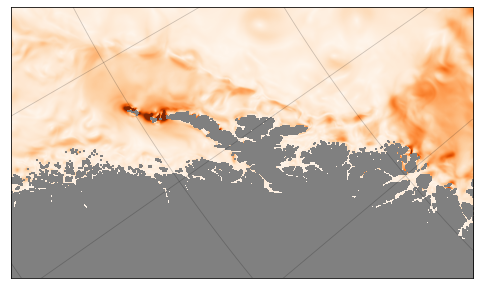

In [11]:
plt.figure(figsize=(10,5))
plt.imshow(op_velo, origin="lower", cmap=vel_cmap, vmin=0, vmax=vmax, extent=op_domain_extent)

plt.contour(op_lon, levels = np.arange(0, 90, 5.0), extent=op_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(op_lat, levels = np.arange(0, 90, 2.5), extent=op_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("OceanModel_operational.pdf", dpi=600, bbox_inches="tight")

In [12]:
from gpuocean.utils import PlotHelper

eta, hu, hv = sim.download(interior_domain_only=True)
_, Hm = sim.downloadBathymetry(interior_domain_only=True)
velo = PlotHelper.genVelocity(Hm+eta, hu, hv)

In [13]:
simp_ny, simp_nx = velo.shape
simp_domain_extent = [0, simp_nx*dx/1000, 0, simp_ny*dy/1000]

In [14]:
simp_lat = lat[452:748, 1402:1898]
simp_lon = lon[452:748, 1402:1898]

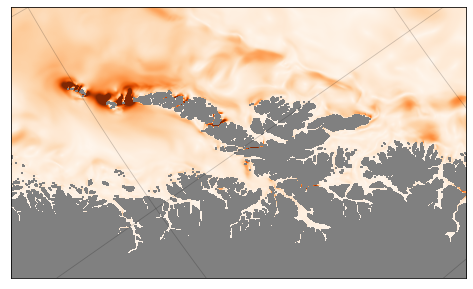

In [15]:
plt.figure(figsize=(10,5))
plt.imshow(velo, origin="lower", cmap=vel_cmap, vmin=0, vmax=vmax, extent=simp_domain_extent)

plt.contour(simp_lon, levels = np.arange(0, 90, 5.0), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(simp_lat, levels = np.arange(0, 90, 2.5), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

# plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.savefig("OceanModel_simplified.pdf", dpi=600, bbox_inches="tight", pad_inches=0.1)

c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  


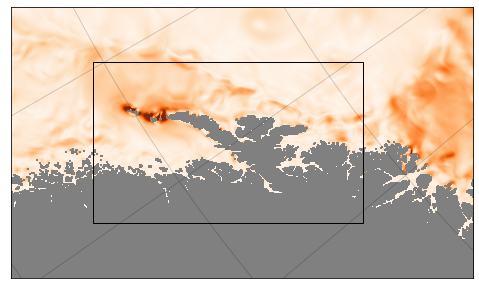

In [20]:
import matplotlib.patches as patches
plt.figure(figsize=(10,5))

plt.imshow(op_velo, origin="lower", cmap=vel_cmap, vmin=0, vmax=vmax, extent=op_domain_extent)

plt.contour(op_lon, levels = np.arange(0, 90, 5.0), extent=op_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(op_lat, levels = np.arange(0, 90, 2.5), extent=op_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)


rect = patches.Rectangle(((1402-op_x0)*dx/1000, (452-op_y0)*dx/1000), simp_nx*dx/1000, simp_ny*dx/1000, edgecolor='black', facecolor='none', linewidth=1)
plt.gca().add_patch(rect)
plt.xticks([])
plt.yticks([])
plt.savefig("OceanModels_nested.pdf", dpi=600, bbox_inches="tight", linewidth=2)


## Observations

In [17]:
grey_vel_cmap = copy.copy(plt.cm.Greys)
grey_vel_cmap.set_bad(color='grey')

In [155]:
sim_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url, casename)
sim.step(3*3600)

eta, hu, hv = sim.download(interior_domain_only=True)
velo = PlotHelper.genVelocity(Hm+eta, hu, hv)

21600.0

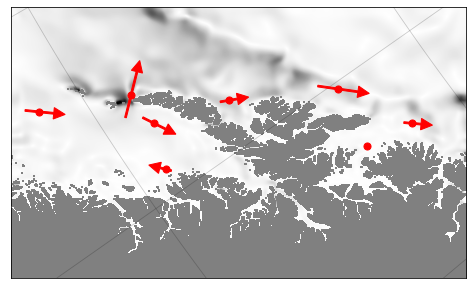

In [157]:
def mark_observation(midpoint, direction):
    # Add a dot at the midpoint
    plt.scatter(*midpoint, color="red", s=50)

    # Add the arrow with the dot at its midpoint
    direction = tuple([20*d for d in direction])
    if direction[0]>0 or direction[1]>0:
        plt.arrow(midpoint[0] - 0.5 * direction[0], midpoint[1] - 0.5 * direction[1],
              direction[0], direction[1], color="red", width=1.5, head_width=10, head_length=10,length_includes_head=False)

plt.figure(figsize=(10,5))
plt.imshow(velo, origin="lower", cmap=grey_vel_cmap, vmin=0, vmax=0.75, extent=simp_domain_extent)

plt.contour(simp_lon, levels = np.arange(0, 90, 5.0), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(simp_lat, levels = np.arange(0, 90, 2.5), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

mark_observation((125,135), (1,-0.5))
mark_observation((190,155), (0.75,0.125))
mark_observation((105,160), (0.5,2))
mark_observation((135,95), (-0.5,0.125))
mark_observation((25,145), (1.25,-0.125))
mark_observation((310,115), (0,0))
mark_observation((350,135), (0.75,-0.0675))
mark_observation((285,165), (1.75,-0.25))

plt.xticks([])
plt.yticks([])
plt.savefig("OceanModel_observation.pdf", dpi=600, bbox_inches="tight")

## Vorticity

In [81]:
T_hours = 3

In [82]:
vor_cmap = copy.copy(plt.cm.seismic)
vor_cmap.set_bad(color='grey')

In [118]:
R_min = -vmax/2500
R_max = vmax/2500

In [128]:
coarse_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 0.5)

coarse_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(coarse_sim_args))
coarse_sim.step(T_hours*3600)

coarse_eta, coarse_hu, coarse_hv = coarse_sim.download(interior_domain_only=True)
_, coarse_Hm = coarse_sim.downloadBathymetry(interior_domain_only=True)

C:\Users\florianb\Documents\havvarsel\gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:223: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [129]:
coarse_R = PlotHelper.genColors(coarse_Hm+coarse_eta, coarse_hu/coarse_sim.dx, coarse_hv/coarse_sim.dy, vor_cmap, R_min, R_max)

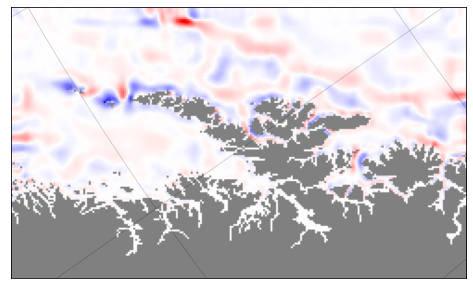

In [145]:
plt.figure(figsize=(10,5))
plt.imshow(coarse_R, origin="lower", extent=simp_domain_extent)

plt.contour(simp_lon, levels = np.arange(0, 90, 5.0), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(simp_lat, levels = np.arange(0, 90, 2.5), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_1600.pdf", dpi=600, bbox_inches="tight")

In [84]:
sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(sim_args))
sim.step(T_hours*3600)

eta, hu, hv = sim.download(interior_domain_only=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [119]:
R = PlotHelper.genColors(Hm+eta, hu/sim.dx, hv/sim.dy, vor_cmap, R_min, R_max)


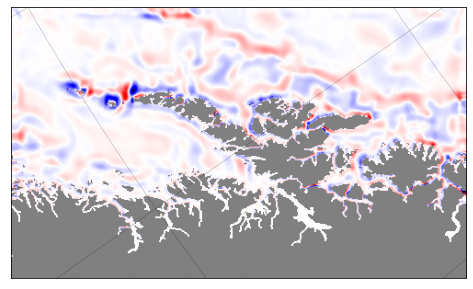

In [146]:
plt.figure(figsize=(10,5))
plt.imshow(R, origin="lower", extent=simp_domain_extent)

plt.contour(simp_lon, levels = np.arange(0, 90, 5.0), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(simp_lat, levels = np.arange(0, 90, 2.5), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_800.pdf", dpi=600, bbox_inches="tight")

In [133]:
fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 2)

fine_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(fine_sim_args))
fine_sim.step(T_hours*3600)

fine_eta, fine_hu, fine_hv = fine_sim.download(interior_domain_only=True)
_, fine_Hm = fine_sim.downloadBathymetry(interior_domain_only=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


KeyboardInterrupt: 

In [135]:
fine_R = PlotHelper.genColors(fine_Hm+fine_eta, fine_hu/fine_sim.dx, fine_hv/fine_sim.dy, vor_cmap, R_min, R_max)

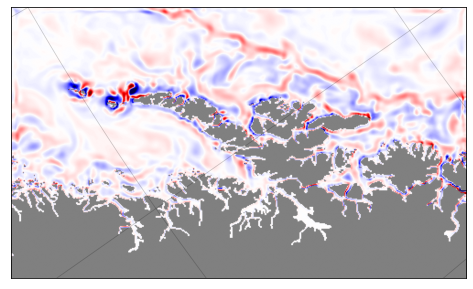

In [147]:
plt.figure(figsize=(10,5))
plt.imshow(fine_R, origin="lower", extent=simp_domain_extent)

plt.contour(simp_lon, levels = np.arange(0, 90, 5.0), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(simp_lat, levels = np.arange(0, 90, 2.5), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_400.pdf", dpi=600, bbox_inches="tight")

In [100]:
extra_fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 4)

extra_fine_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(extra_fine_sim_args))
extra_fine_sim.step(T_hours*3600)

extra_fine_eta, extra_fine_hu, extra_fine_hv = extra_fine_sim.download(interior_domain_only=True)
_, extra_fine_Hm = extra_fine_sim.downloadBathymetry(interior_domain_only=True)

C:\Users\florianb\Documents\havvarsel\gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:223: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [137]:
extra_fine_R = PlotHelper.genColors(extra_fine_Hm+extra_fine_eta, extra_fine_hu/extra_fine_sim.dx, extra_fine_hv/extra_fine_sim.dy, vor_cmap, R_min, R_max)

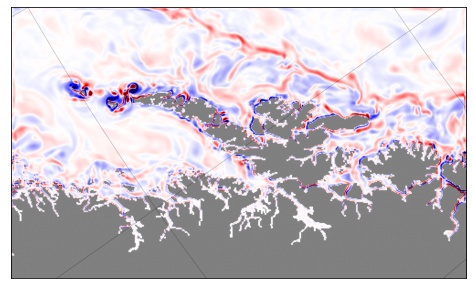

In [148]:
plt.figure(figsize=(10,5))
plt.imshow(extra_fine_R, origin="lower", extent=simp_domain_extent)

plt.contour(simp_lon, levels = np.arange(0, 90, 5.0), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(simp_lat, levels = np.arange(0, 90, 2.5), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_200.pdf", dpi=600, bbox_inches="tight")

In [90]:
op_h = nc["h"][452:748, 1402:1898] + nc["zeta"][T_hours][452:748, 1402:1898]
op_hu = nc["ubar"][T_hours][452:748, 1402:1898] * op_h
op_hv = nc["vbar"][T_hours][452:748, 1402:1898] * op_h

op_R = PlotHelper.genColors(op_h, op_hu/dx, op_hv/dy, vor_cmap, R_min, R_max)

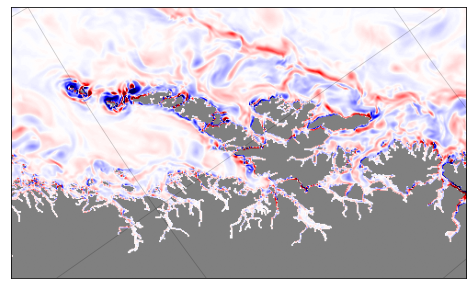

In [149]:
plt.figure(figsize=(10,5))
plt.imshow(op_R, origin="lower", extent=simp_domain_extent)

plt.contour(simp_lon, levels = np.arange(0, 90, 5.0), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(simp_lat, levels = np.arange(0, 90, 2.5), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_operational.pdf", dpi=600, bbox_inches="tight")

### Velocities

In [152]:
coarse_V = PlotHelper.genVelocity(coarse_Hm+coarse_eta, coarse_hu, coarse_hv)

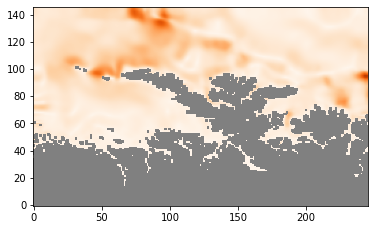

In [153]:
plt.imshow(coarse_V, origin="lower", vmin=0, vmax=vmax, cmap=vel_cmap)

In [103]:
V = PlotHelper.genVelocity(Hm+eta, hu, hv)

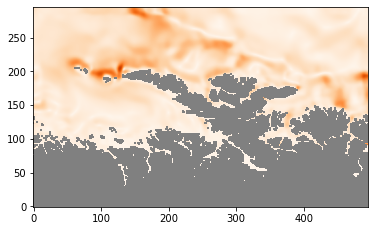

In [104]:
plt.imshow(V, origin="lower", vmin=0, vmax=vmax, cmap=vel_cmap)

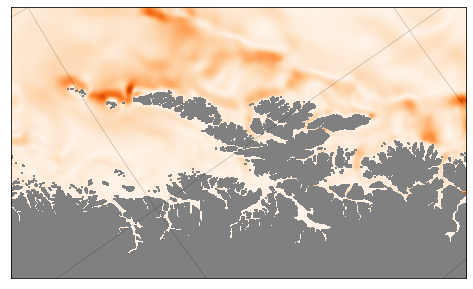

In [154]:
plt.figure(figsize=(10,5))
plt.imshow(V, origin="lower", cmap=vel_cmap, vmin=0, vmax=vmax, extent=simp_domain_extent)

plt.contour(simp_lon, levels = np.arange(0, 90, 5.0), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(simp_lat, levels = np.arange(0, 90, 2.5), extent=simp_domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

# plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.savefig("OceanModel_simplified2.pdf", dpi=600, bbox_inches="tight", pad_inches=0.1)

In [105]:
fine_V = PlotHelper.genVelocity(fine_Hm+fine_eta, fine_hu, fine_hv)

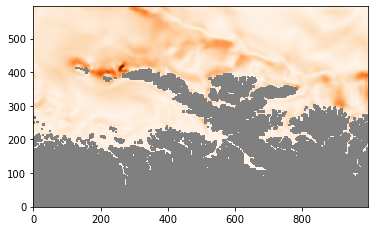

In [106]:
plt.imshow(fine_V, origin="lower", vmin=0, vmax=vmax, cmap=vel_cmap)

In [107]:
extra_fine_V = PlotHelper.genVelocity(extra_fine_Hm+extra_fine_eta, extra_fine_hu, extra_fine_hv)

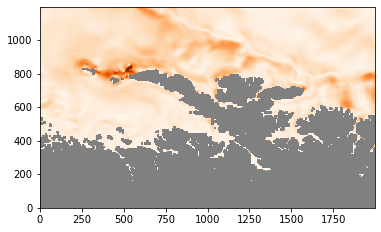

In [108]:
plt.imshow(extra_fine_V, origin="lower", vmin=0, vmax=vmax, cmap=vel_cmap)

In [109]:
op_V = PlotHelper.genVelocity(op_h, op_hu, op_hv)

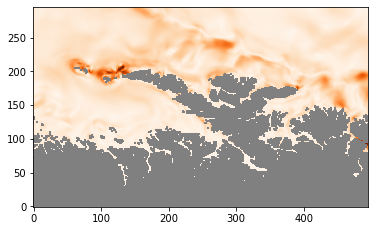

In [110]:
plt.imshow(op_V, origin="lower", vmin=0, vmax=vmax, cmap=vel_cmap)